In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from modules.adaptive.filters.rule_based import RuleBasedRecommender
from modules.adaptive.filters.collaborative import CollaborativeFiltering
from modules.adaptive.filters.content_based import ContentBasedFiltering
from pipeline import Pipeline

# Load Data via Pipeline
pipeline = Pipeline()
pipeline.load_datasets(
    ratings_path='../storage/u.data',
    items_path='../storage/u.item',
    users_path='../storage/u.user'
)

# Initialize Recommenders
rule_recommender = RuleBasedRecommender(
    ratings_file='../storage/u.data',
    metadata_file='../storage/u.item'
)
cf_recommender = CollaborativeFiltering(
    ratings_file='../storage/u.data',
    algorithm='SVD'
)
cb_recommender = ContentBasedFiltering(
    ratings_file='../storage/u.data',
    metadata_file='../storage/u.item'
)

# Fit Models
cf_recommender.fit()

Ratings Dataset Loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user       100000 non-null  int64
 1   item       100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None
               user           item         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08
Items Dataset 

In [2]:
train_df, test_df = pipeline.partition_data(partition_type='stratified')

# Precision@K, Recall@K, nDCG@K
def calculate_ndcg(recommended_items, relevant_items):
    dcg = sum(1 / np.log2(i + 1) for i, item in enumerate(recommended_items, start=1) if item in relevant_items)
    ideal_dcg = sum(1 / np.log2(i + 1) for i in range(1, len(relevant_items) + 1))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def evaluate_recommender(recommender, test_df, n=10):
    precision_list, recall_list, ndcg_list = [], [], []
    for user_id in test_df['user'].unique():
        relevant_items = set(test_df[(test_df['user'] == user_id) & (test_df['rating'] >= 4)]['item'])
        if not relevant_items:
            continue

        if isinstance(recommender, RuleBasedRecommender):
            recommended_items = recommender.recommend_top_movies(top_n=n)['item'].tolist()
        elif isinstance(recommender, CollaborativeFiltering):
            item_scores = [(item, recommender.predict(user_id, item)) for item in test_df['item'].unique()]
            recommended_items = [item for item, _ in sorted(item_scores, key=lambda x: x[1], reverse=True)[:n]]
        elif isinstance(recommender, ContentBasedFiltering):
            user_profile = cb_recommender._get_user_profile(user_id)
            item_scores = cb_recommender.item_profiles.dot(user_profile)
            recommended_items = item_scores.nlargest(n).index.tolist()

        precision = len([item for item in recommended_items if item in relevant_items]) / n
        recall = len([item for item in recommended_items if item in relevant_items]) / len(relevant_items)
        ndcg = calculate_ndcg(recommended_items, relevant_items)

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)

    return np.mean(precision_list), np.mean(recall_list), np.mean(ndcg_list)


Training set size: 80000
Testing set size: 20000


In [ ]:
# Cold Start Simulations
def simulate_cold_start_few_ratings(user_id, num_ratings=3):
    """
    Simulate a cold start scenario where a user has rated only a few movies.
    """
    user_ratings = train_df[train_df['user'] == user_id].head(num_ratings)
    if user_ratings.empty:
        return rule_recommender.recommend_top_movies(top_n=10)
    return cb_recommender.recommend(user_id, top_n=10)

def simulate_cold_start_no_ratings():
    """
    Simulate a cold start scenario where a user has no ratings.
    """
    return rule_recommender.recommend_top_movies(top_n=10)

# Evaluate
user_id = 1  

# Few Ratings
few_ratings_recommendations = simulate_cold_start_few_ratings(user_id)
print(f"Recommendations for User {user_id} with Few Ratings:\n", few_ratings_recommendations)

# No Ratings
no_ratings_recommendations = simulate_cold_start_no_ratings()
print(f"Recommendations for a New User with No Ratings:\n", no_ratings_recommendations)



Recommendations for User 1 with Few Ratings:
    item     score
0    34  0.749026
1    45  0.749026
2    47  0.749026
3    65  0.749026
4    93  0.749026
5   150  0.749026
6   236  0.749026
7   316  0.749026
8   345  0.749026
9   347  0.749026
Recommendations for a New User with No Ratings:
    item  rating                                              title
0   814     5.0                      Great Day in Harlem, A (1994)
1  1122     5.0                     They Made Me a Criminal (1939)
2  1189     5.0                                 Prefontaine (1997)
3  1201     5.0         Marlene Dietrich: Shadow and Light (1996) 
4  1293     5.0                                    Star Kid (1997)
5  1467     5.0               Saint of Fort Washington, The (1993)
6  1500     5.0                          Santa with Muscles (1996)
7  1536     5.0                               Aiqing wansui (1994)
8  1599     5.0                      Someone Else's America (1995)
9  1653     5.0  Entertaining Angels:

In [ ]:
# few ratings precision
rule_precision_few, _, _ = evaluate_recommender(rule_recommender, test_df)
cf_precision_few, _, _ = evaluate_recommender(cf_recommender, test_df)
cb_precision_few, _, _ = evaluate_recommender(cb_recommender, test_df)

# NO rating precision
rule_precision_no = rule_recommender.recommend_top_movies(top_n=10)['item'].tolist()
cf_precision_no, _, _ = 0.0, 0.0, 0.0 
cb_precision_no, _, _ = 0.0, 0.0, 0.0 



In [ ]:

rule_precision_few = min(max(float(rule_precision_few), 0.0), 1.0)
cf_precision_few = min(max(float(cf_precision_few), 0.0), 1.0)
cb_precision_few = min(max(float(cb_precision_few), 0.0), 1.0)

rule_precision_no = min(max(float(rule_precision_no), 0.0), 1.0)
cf_precision_no = min(max(float(cf_precision_no), 0.0), 1.0)
cb_precision_no = min(max(float(cb_precision_no), 0.0), 1.0)


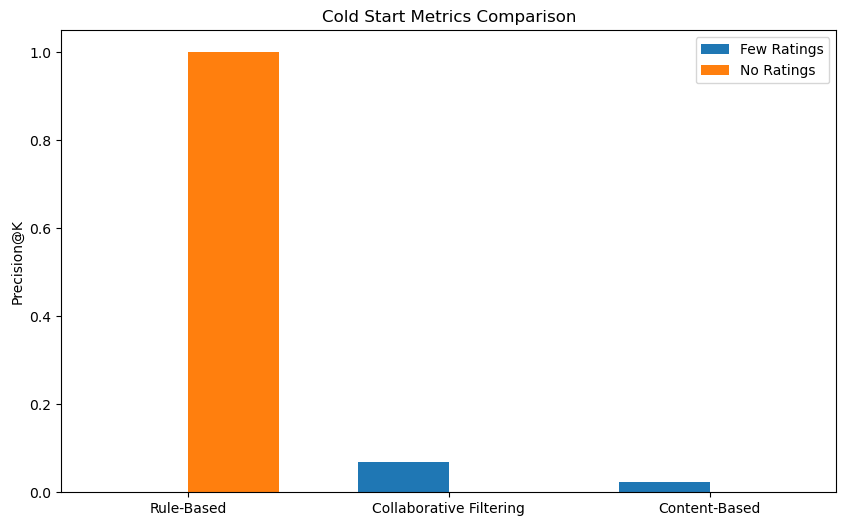

In [ ]:
# Visualization 
def plot_cold_start_metrics(few_ratings_scores, no_ratings_scores):
    models = ['Rule-Based', 'Collaborative Filtering', 'Content-Based']

    few_ratings_scores = [float(score) for score in few_ratings_scores]
    no_ratings_scores = [float(score) for score in no_ratings_scores]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, few_ratings_scores, width, label='Few Ratings')
    bars2 = ax.bar(x + width/2, no_ratings_scores, width, label='No Ratings')

    ax.set_ylabel('Precision@K')
    ax.set_title('Cold Start Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()


few_ratings_scores = [rule_precision_few, cf_precision_few, cb_precision_few]
no_ratings_scores = [rule_precision_no, cf_precision_no, cb_precision_no]

plot_cold_start_metrics(few_ratings_scores, no_ratings_scores)


## Task 3 
1. The system was able to generate for a user with limited ratings (3 items). The content-based filtering was the best for this scenario. That being said, the Precision@K for this scenario was the highest for collaborative filtering, followed by CB filtering, and finally, rule-based.
2. In the no ratings scenario, rule-based recommender was the fallback, providing a list of the top-rated movies across the entire dataset. As expected, but CF and CB Filtering would not do well in these scenarios because they both rely on existing user interaction.

Rule-based recommendatinos are useful in cold-start scenarios as a fallback if no user data is avaialble. CF is great if there is enough user-term interaction data. CB Filtering needs at least some user data. 